# Using the IMF to calculate the mass of a cluster
In this exercise, you define functions that sample an IMF in order to estimate the mass of the cluster, IC 2602

In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imf import imf

import pandas as pd
import numpy as np
from astropy.io import fits, ascii
import mechanize
from glob import glob
import os
import re

%matplotlib widget

## Step 1
Write functions for the Chabrier, Salpeter, and Kroupa IMFs, that each take as input an array of masses between .01 and 100 solar masses, and return the IMFs. Plot all three. 

In [412]:
m = np.logspace(-2, 2, 1000000) # <-- Use this mass range for defining the IMFs. It needs enough samples to be smooth for integration. 


# Solution 1: If they were attentive in the lecture, they would remember that Joao showed how to do this in class. It's on the Moodle page.
def kroupa_imf(m):
    m = np.array(m)
    imf = np.zeros_like(m)
    imf[m < 0.08] = m[m < 0.08]**-0.3
    imf[(m >= 0.08) & (m < 0.5)] = 0.08**-0.3 * (m[(m >= 0.08) & (m < 0.5)] / 0.08)**-1.3
    imf[m >= 0.5] = 0.08**-0.3 * (0.5 / 0.08)**-1.3 * (m[m >= 0.5] / 0.5)**-2.3
    return imf

def chabrier_imf(m):
    m = np.array(m)
    imf = np.zeros_like(m)
    imf[m < 1] = (0.158 / m[m < 1]) * np.exp(-((np.log10(m[m < 1]) - np.log10(0.08))**2) / (2 * 0.69**2))
    imf[m >= 1] = 0.158 * np.exp(-((np.log10(1) - np.log10(0.08))**2) / (2 * 0.69**2)) * m[m >= 1]**-2.3
    return imf

def salpeter_imf(m):
    m = np.array(m)
    return m**-2.35

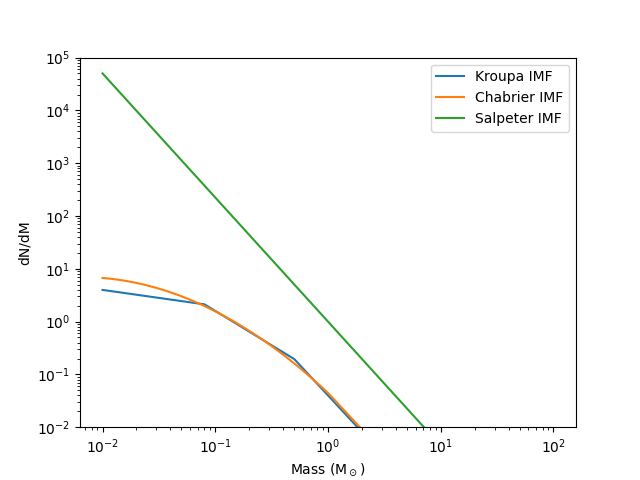

In [413]:
# Solution 1: Continued
kimf = kroupa_imf(m)
cimf = chabrier_imf(m)
simf = salpeter_imf(m)

plt.figure()
plt.plot(m, kimf, label='Kroupa IMF')
plt.plot(m, cimf, label='Chabrier IMF')
plt.plot(m, simf, label='Salpeter IMF')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(.01,100000)
plt.xlabel('Mass (M$_\odot$)')
plt.ylabel('dN/dM')
plt.show()

## Step 2
The IMF can be converted to a probability density function (PDF) and cumulative distribution function (CDF) when given the total mass of the cluster. Write a function that takes in an IMF and a value for the total mass and returns the distribution of masses in the cluster. (Hint: This requires inverse-sampling: https://en.wikipedia.org/wiki/Inverse_transform_sampling)

In [414]:
# Compute the IMF and normalize it to a PDF
imf = kroupa_imf(m)
pdf = imf / np.trapz(imf, m)  # Normalize using the trapezoidal rule for integration

# Compute the cumulative distribution function (CDF)
cdf = np.cumsum(pdf * np.diff(m, prepend=m[0]))

# Function to sample masses using inverse transform sampling
def sample_cluster(m, cdf, total_mass):
    sampled_masses = []
    current_mass = 0
    while current_mass < total_mass:
        rnd = np.random.uniform(0, 1)  # Random number between 0 and 1
        idx = min(np.searchsorted(cdf, rnd), len(m) - 1)  # Ensure index is within bounds
        sampled_mass = m[idx]
        sampled_masses.append(sampled_mass)
        current_mass += sampled_mass
    return np.array(sampled_masses)

# Generate a cluster with a total mass of 1000 solar masses
total_mass = 1000  # Target cluster mass in solar masses
cluster_masses = sample_cluster(m, cdf, total_mass)

print(f"Generated cluster with {len(cluster_masses)} stars and total mass: {cluster_masses.sum():.2f} M_sun")

Generated cluster with 2726 stars and total mass: 1000.17 M_sun


## Step 2 (continued)
Using a Kroupa IMF, how many massive stars (> 8 solar masses) are likely to be formed by a 1000 solar mass cluster. Report the median and standard deviations. 

In [415]:
n_massive = []
for i in range(100):
    cluster_masses = sample_cluster(m, cdf, total_mass)
    n_massive.append(len(cluster_masses[cluster_masses > 8]))
print(f"Average number of massive stars: {np.mean(n_massive):.1f}")
print(f"Standard deviation: {np.std(n_massive):.1f}")

Average number of massive stars: 10.8
Standard deviation: 3.1


## Step 3
The following cell loads in the data and best-fit isochrone model for the 26 Myr old cluster, IC 2602. Plot the color-magnitude diagram (BP - RP versus G_abs). 

In [416]:
# read isochrone
iso = ascii.read('isochrone.dat', header_start = 14).to_pandas()
iso_g = iso['Gmag'].values
iso_bp = iso['G_BPmag'].values
iso_rp = iso['G_RPmag'].values

# read cluster
c = pd.read_csv('IC_2602.csv')

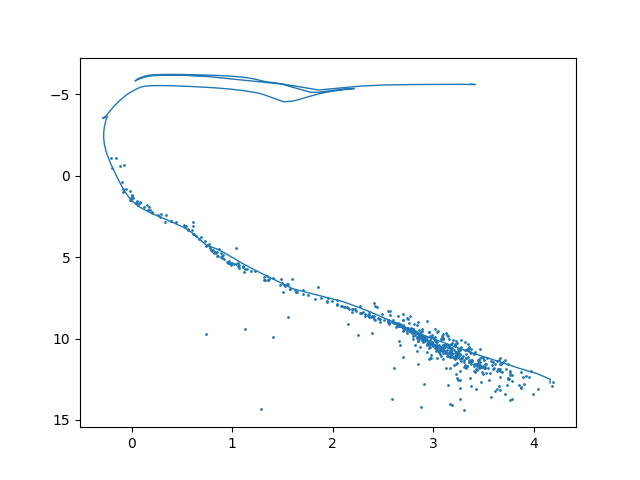

In [417]:

plt.figure()
plt.scatter(c['G_BPmag'] - c['G_RPmag'], c['Gmag_abs'], s=1, label='IC 2602')
plt.plot(iso['G_BPmag'] - iso['G_RPmag'], iso['Gmag'], lw=1, label='Isochrone')
plt.gca().invert_yaxis()
plt.show()


# Step 3 (continued)
Use the isochrone model, which includes information on stellar 'Mass', to estimate the masses of the stars in IC 2602. (Hint: Find the nearest matching point on the isochrone for each star)

In [418]:
# Create arrays for the isochrone data
iso_colors = iso_bp - iso_rp
iso_mags = iso_g
iso_mass = iso['Mass'].values

# Get the color and magnitude of the cluster stars
cluster_colors = c['G_BPmag'] - c['G_RPmag']
cluster_mags = c['Gmag_abs']

# Create a 2D array for the isochrone and cluster data
iso_data = np.vstack((iso_colors, iso_mags)).T
cluster_data = np.vstack((cluster_colors, cluster_mags)).T

# Compute the distances between each cluster star and all isochrone points
distances = np.linalg.norm(cluster_data[:, np.newaxis, :] - iso_data, axis=2)

# Find the index of the nearest isochrone point for each cluster star
indices = np.argmin(distances, axis=1)

# Assign the mass from the isochrone to the cluster stars
c['Mass'] = iso_mass[indices]

## Step 4: 
Plot a histogram of the cluster's mass distribution. 

It is important to note that this mass distribution isn't complete. Gaia is limited at both the low and high mass ends of the mass function, meaning your plotted distribution is missing mass. 

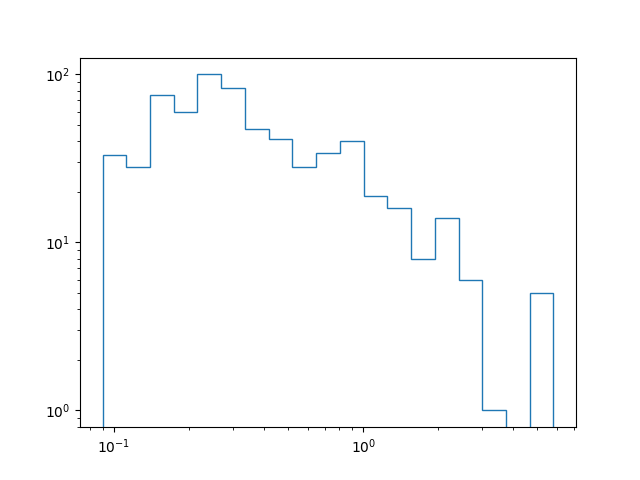

In [419]:
plt.figure()
plt.hist(c['Mass'], bins=np.logspace(np.log10(c['Mass'].min()), np.log10(c['Mass'].max()), 20), histtype='step', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.show()

# 

## Step 4 (continued):
To estimate the total, initial mass of the cluster, you can find an IMF that matches the observed mass of the cluster within a mass range that is observationally complete. For Gaia, this is roughly between 0.5 and 2 solar masses for nearby clusters. 

Use your IMF sampling code to find an IMF that best matches the observed mass distribution of IC 2602-- within the completeness bounds. Plot the best imf on top of the observed mass distribution and report the mass of this IMF, which is now your estimated total mass for the cluster. 

In [420]:
m_min_complete = 0.5
m_max_complete = 2

M_total_to_sample = np.arange(np.sum(c['Mass']), np.sum(c['Mass']) + 500, 1)

diffs = []
imfs = []
for Mtot in M_total_to_sample:
    cluster_masses = sample_cluster(m, cdf, Mtot)
    m_within_range_imf = np.sum(cluster_masses[(cluster_masses > m_min_complete) & (cluster_masses < m_max_complete)])
    m_within_range_observed = np.sum(c['Mass'][(c['Mass'] > m_min_complete) & (c['Mass'] < m_max_complete)])
    diffs.append(m_within_range_imf - m_within_range_observed)
    imfs.append(cluster_masses)
Mtot_best = M_total_to_sample[np.argmin(np.abs(diffs))]
imf_best = imfs[np.argmin(np.abs(diffs))]
print(Mtot_best)

523.328


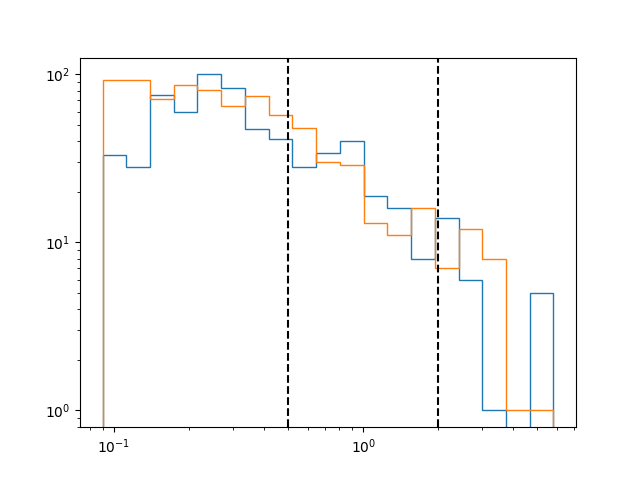

In [421]:
plt.figure()
plt.hist(c['Mass'], bins=np.logspace(np.log10(c['Mass'].min()), np.log10(c['Mass'].max()), 20), histtype='step', lw=2)
plt.hist(imf_best, bins=np.logspace(np.log10(c['Mass'].min()), np.log10(c['Mass'].max()), 20), histtype='step', lw=2)
plt.axvline(m_min_complete, color='k', ls='--')
plt.axvline(m_max_complete, color='k', ls='--')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Step 5 (bonus)
Given the best-fitting isochrone for IC 2602 and the best IMF that you have just computed, how many supernovae have already occured in the cluster? (Hint: Stars > 8 solar masses go supernovae, but the time this happens depends on their age.)

In [422]:
m_massive = imf_best[imf_best > 8]
most_massive_star_alive = np.max(iso['Mass'])

print('N stars that have exploded: ', len(m_massive[m_massive > most_massive_star_alive]))
print('N stars that will explode in future: ', len(m_massive[m_massive <= most_massive_star_alive]))

N stars that have exploded:  5
N stars that will explode in future:  1


In [423]:
m_massive[m_massive > most_massive_star_alive]

array([37.65889528, 30.18140685, 10.36924213, 11.8689165 , 12.593055  ])

In [424]:
# # Cam extra

# # stars = pd.read_csv('/Users/cam/Downloads/members-2.csv')
# # c = stars.loc[stars['name'] == 'IC_2391']

# def get_isochrone(age, extinction):
#     print('Retrieving isochorne with age = {} Myr and extinction = {}'.format(age, extinction))
#     br = mechanize.Browser()
#     br.open('http://stev.oapd.inaf.it/cgi-bin/cmd')
#     log_age = np.round(np.log10(age*1e6), 5)
#     br.select_form(nr=0)
#     br['extinction_av'] = str(extinction)
#     br['isoc_isagelog'] = ['1',]
#     br['isoc_lagelow'] = str(log_age)
#     br['isoc_lageupp'] = str(log_age)
#     #br['isoc_dlage'] = str(0.0)
#     br['isoc_zlow'] = str(0.0152)
#     br['isoc_zupp'] = str(0.0152)
#     br['isoc_dz'] = str(0.0)
#     br['photsys_file'] = ['YBC_tab_mag_odfnew/tab_mag_gaiaEDR3.dat',]
    

#     response = br.submit()  
#     string_response = str(response.read())
#     substring = 'output.\d*.dat'
#     temp = re.compile(substring)
#     res = temp.search(string_response)
#     filename = res[0]
#     url_to_retrieve = 'http://stev.oapd.inaf.it/tmp/{}'.format(filename)
#     br.retrieve(url_to_retrieve, './isochrone.dat')

# get_isochrone(26, 0.11)